In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('food_nutrition.csv')


In [75]:
df.columns


Index(['NDB_No', 'Long_Desc', 'Msre_Desc', 'Gm_Wgt', 'Water_g', 'Energ_Kcal',
       'Protein_g', 'Lipid_Tot_g', 'Ash_g', 'Carbohydrt_g', 'Fiber_TD_g',
       'Sugar_Tot_g', 'Calcium_mg', 'Iron_mg', 'Magnesium_mg', 'Phosphorus_mg',
       'Potassium_mg', 'Sodium_mg', 'Zinc_mg', 'Copper_mg', 'Manganese_mg',
       'Selenium_µg', 'Vit_C_mg', 'Thiamin_mg', 'Riboflavin_mg', 'Niacin_mg',
       'Panto_Acid_mg', 'Vit_B6_mg', 'Folate_Tot_µg', 'Food_Folate_µg',
       'Folate_DFE_µg', 'Choline_Tot_mg', 'Vit_B12_µg', 'Vit_A_RAE',
       'Retinol_µg', 'Alpha_Carot_µg', 'Beta_Carot_µg', 'Beta_Crypt_µg',
       'Lycopene_µg', 'LutZea_ug', 'Vit_E_mg', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_µg', 'FA_Poly_g', 'Cholestrl_mg', 'GmWt_1', 'GmWt_Desc1',
       'GmWt_2', 'GmWt_Desc2', 'Refuse_Pct'],
      dtype='object')

## Creating a Health score

In [76]:
# nutrients tiers defined
macro_nutrients = ['Protein_g', 'Carbohydrt_g', 'Lipid_Tot_g', 'Sugar_Tot_g','Fiber_TD_g', 'Sodium_mg', 'Potassium_mg']

minerals = [
    'Calcium_mg', 'Iron_mg', 'Magnesium_mg',
    'Phosphorus_mg', 'Zinc_mg', 'Copper_mg',
    'Manganese_mg', 'Selenium_µg'
]

vitamins = [
    'Vit_C_mg', 'Thiamin_mg', 'Riboflavin_mg', 'Niacin_mg', 'Panto_Acid_mg',
    'Vit_B6_mg', 'Folate_Tot_µg', 'Food_Folate_µg', 'Folate_DFE_µg',
    'Choline_Tot_mg', 'Vit_B12_µg', 'Vit_A_RAE', 'Retinol_µg',
    'Alpha_Carot_µg', 'Beta_Carot_µg', 'Beta_Crypt_µg', 'Lycopene_µg',
    'LutZea_ug', 'Vit_E_mg', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_µg'
]

# non nutritional columns
non_nutrition = ['NDB_No', 'Long_Desc', 'Msre_Desc', 'Gm_Wgt', 'GmWt_1', 'GmWt_Desc1', 
                 'GmWt_2', 'GmWt_Desc2', 'Refuse_Pct']


# set weights
weights = {
    'macro_nutrients':0.5,
    'minerals': 0.3,
    'vitamins': 0.2
}

In [77]:
# normalize nutrient columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
nutrients = core_nutrients + minerals + vitamins

df_scaled = df.copy()

df_scaled[nutrients] = scaler.fit_transform(df_scaled[nutrients])

In [78]:
# subscores for each category
df_scaled['score_macro'] = df_scaled[core_nutrients].mean(axis=1)
df_scaled['score_minerals'] = df_scaled[minerals].mean(axis=1)
df_scaled['score_vitamins'] = df_scaled[vitamins].mean(axis=1)

df_scaled['Health_Score'] = (
    df_scaled['score_macro'] * weights['macro_nutrients'] +
    df_scaled['score_minerals'] * weights['minerals'] +
    df_scaled['score_vitamins'] * weights['vitamins']
)

# scale health score to 0-100
df_scaled['Health_Score'] = 100 * (
    (df_scaled['Health_Score'] - df_scaled['Health_Score'].min()) /
    (df_scaled['Health_Score'].max() - df_scaled['Health_Score'].min())
)

#### Penalty system for excessive sugar, sodium or cholestrol

In [79]:
# Define penalty system (per 100g serving) ---
penalty_thresholds = {
    'Sugar_Tot_g': 15,        # >15g sugar → sugary food
    'Sodium_mg': 500,         # >500mg sodium → high salt
    'Cholestrl_mg': 100,      # >100mg cholesterol → high fat/meat
    'FA_Sat_g': 5             # >5g saturated fat → high saturated fat
}

penalty_weights = {
    'Sugar_Tot_g': 0.15,
    'Sodium_mg': 0.25,
    'Cholestrl_mg': 0.2,
    'FA_Sat_g': 0.2
}

# Apply penalties ---
df_penalty = df_scaled.copy()

for nutrient, threshold in penalty_thresholds.items():
    if nutrient in df_penalty.columns:
        excess = (df_penalty[nutrient] > threshold).astype(int)
        df_penalty[f"{nutrient}_penalty"] = excess * penalty_weights[nutrient] * 100

# Sum total penalty
penalty_cols = [c for c in df_penalty.columns if c.endswith('_penalty')]
df_penalty['Total_Penalty'] = df_penalty[penalty_cols].sum(axis=1)

#  Adjust health score (floor at 0, cap at 100) ---
df_penalty['New_Health_Score'] = (
    df_penalty['Health_Score'] - df_penalty['Total_Penalty']
).clip(lower=0, upper=100)

# Categorize before and after penalty ---
def categorize_health(score):
    if score >= 75:
        return "Excellent"
    elif score >= 50:
        return "Good"
    elif score >= 25:
        return "Fair"
    else:
        return "Poor"

df_penalty['Health_Category'] = df_penalty['Health_Score'].apply(categorize_health)
df_penalty['New_Category'] = df_penalty['New_Health_Score'].apply(categorize_health)



In [80]:
# Display final preview ---
df_penalty[['Long_Desc', 'Health_Score', 'New_Health_Score','Health_Category',
            'New_Category']].head(10)

,Long_Desc,Health_Score,New_Health_Score,Health_Category,New_Category
0,unknown,19.704467,0.000000,Poor,Poor
1,unknown,19.233351,0.000000,Poor,Poor
2,unknown,14.683385,0.000000,Poor,Poor
3,unknown,34.944399,34.944399,Fair,Fair
4,unknown,32.356278,32.356278,Fair,Fair
5,unknown,25.732186,25.732186,Fair,Fair
6,unknown,29.636217,29.636217,Fair,Fair
7,unknown,34.307743,34.307743,Fair,Fair
8,unknown,35.372116,35.372116,Fair,Fair
9,unknown,33.378986,13.378986,Fair,Poor


<Axes: >

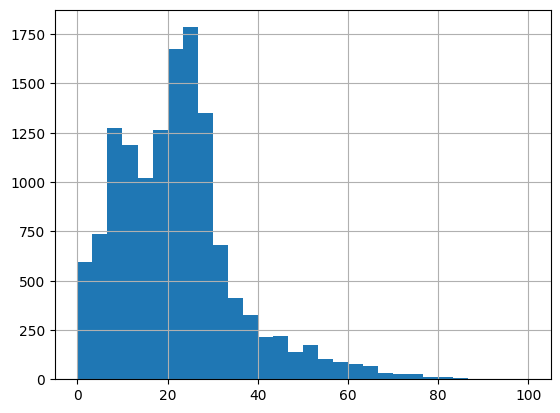

In [81]:
df_final = df_penalty.copy()

df_final['New_Health_Score'].hist(bins=30)

## Clustering